## 1. Data source: PAMAP2 (UCI)

**Dataset:** *PAMAP2 Physical Activity Monitoring* (UCI Machine Learning Repository)

- **UCI dataset page (download + description):**
    - https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring  
- **Local path (expected):** download and unzip the dataset into `./data/pamap2/` (the `data/` directory is not committed to git)  
- **Dataset readme (format / notes):**  
    - https://archive.ics.uci.edu/ml/machine-learning-databases/00231/readme.pdf  
- **License:** Creative Commons Attribution 4.0 International (**CC BY 4.0**)

PAMAP2 is a public wearable-sensing dataset for **human activity recognition (HAR)**. It contains recordings from **9 subjects** performing **18 labeled activities** (plus label `0` for transient/other) while wearing three IMU sensors (**hand/wrist**, **chest**, **ankle**) and a heart-rate monitor.

**File format (from the dataset readme):** each row has **54 columns**:
- `1` timestamp (s)  
- `2` activityID  
- `3` heart rate (bpm)  
- `4–20` IMU hand (wrist)  
- `21–37` IMU chest  
- `38–54` IMU ankle  

Each IMU block contains:
- temperature (°C)  
- 3D accelerometer (±16g) and 3D accelerometer (±6g)  
- 3D gyroscope (rad/s)  
- 3D magnetometer (μT)  
- orientation (not valid in this collection)  

**Activity IDs (18 activities + transient):**
1 lying; 2 sitting; 3 standing; 4 walking; 5 running; 6 cycling; 7 Nordic walking;  
9 watching TV; 10 computer work; 11 car driving; 12 ascending stairs; 13 descending stairs;  
16 vacuum cleaning; 17 ironing; 18 folding laundry; 19 house cleaning; 20 playing soccer; 24 rope jumping;  
0 other (transient activities)

**What we use in this notebook:** **Protocol** recordings only, with a **watch-like setup**: wrist IMU signals (ACC/GYRO/MAG) as inputs and the **activityID** as the multi-class label. We **exclude label `0`** (“transient/other”) to keep the benchmark focused on the defined activities.


## 2. Load data & quick sanity checks

We load the **Protocol** recordings (one file per subject) from `./data/pamap2/`. The raw `.dat` files do not include column headers, so we explicitly assign the **54 columns** defined in the dataset readme. A `subject_id` is added based on the filename.

As a sanity check, we verify that the raw files match the expected **54-column** structure. After this check passes, we immediately **subset to the wrist/hand signals** plus the minimal metadata needed for HAR (`timestamp_s`, `activity_id`, `subject_id`). We also **drop the orientation channels** because they are stated to be **invalid** in this data collection.

Finally, we summarize **activity coverage per subject** and visualize **subject-wise missingness** for the wrist channels.


In [1]:
from pathlib import Path
import re

import numpy as np
import pandas as pd

# --- Paths ---
DATA_ROOT = Path("../data/pamap2")
PROTOCOL_DIR = DATA_ROOT / "PAMAP2_Dataset" / "Protocol"

# --- Column names (54 total, per PAMAP2 readme structure) ---
# 1 timestamp, 1 activity_id, 1 heart_rate, then 3x IMU blocks (hand/chest/ankle), 17 cols each.
IMU_COLS = [
    "temp_c",
    "acc16_x", "acc16_y", "acc16_z",
    "acc6_x",  "acc6_y",  "acc6_z",
    "gyro_x",  "gyro_y",  "gyro_z",
    "mag_x",   "mag_y",   "mag_z",
    "ori_w",   "ori_x",   "ori_y",   "ori_z",
]

COLS = (
    ["timestamp_s", "activity_id", "heart_rate_bpm"]
    + [f"hand_{c}" for c in IMU_COLS]
    + [f"chest_{c}" for c in IMU_COLS]
    + [f"ankle_{c}" for c in IMU_COLS]
)
assert len(COLS) == 54, f"Expected 54 columns, got {len(COLS)}"

# A small "column map" pattern
COLUMN_MAP = {
    "timestamp_s": "timestamp_s",
    "activity_id": "activity_id",
    "heart_rate_bpm": "heart_rate_bpm",
    # wrist/hand IMU blocks:
    **{f"hand_{c}": f"hand_{c}" for c in IMU_COLS},
}

def _parse_subject_id(path: Path) -> int:
    m = re.search(r"subject(\d+)\.dat$", path.name)
    if not m:
        raise ValueError(f"Could not parse subject id from filename: {path.name}")
    return int(m.group(1))

def load_subject_file(path: Path) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        names=COLS,
        na_values=["NaN"],
        engine="python",
    )
    df.insert(0, "subject_id", _parse_subject_id(path))
    return df

# --- Load all Protocol subject files ---
subject_files = sorted(PROTOCOL_DIR.glob("subject*.dat"))
if not subject_files:
    raise FileNotFoundError(
        f"No subject*.dat files found under: {PROTOCOL_DIR}\n"
        f"Check that you unzipped PAMAP2 into: {DATA_ROOT}"
    )

dfs = [load_subject_file(p) for p in subject_files]
data = pd.concat(dfs, ignore_index=True)

# --- Quick sanity checks ---
print(f"Raw files OK: {data.shape[1] - 1} raw columns (expected 54)")

Raw files OK: 54 raw columns (expected 54)


,n_samples,n_activities (of 19 incl. 0: transient)
subject_id,,
101,376417,13
102,447000,13
103,252833,9
104,329576,12
105,374783,13
106,361817,13
107,313599,12
108,408031,13
109,8477,2


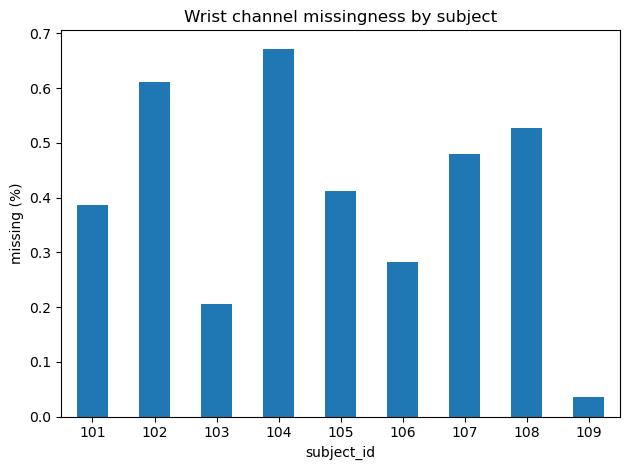

In [2]:
import matplotlib.pyplot as plt

# --- Subset to wrist/hand only + drop invalid orientation channels ---
hand_keep = [
    # temperature
    "hand_temp_c",
    # acc (±16g)
    "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
    # acc (±6g)
    "hand_acc6_x",  "hand_acc6_y",  "hand_acc6_z",
    # gyro
    "hand_gyro_x",  "hand_gyro_y",  "hand_gyro_z",
    # mag
    "hand_mag_x",   "hand_mag_y",   "hand_mag_z",
    # orientation is intentionally dropped: hand_ori_w/x/y/z (invalid in this dataset)
]
data = data[["subject_id", "timestamp_s", "activity_id"] + hand_keep]
# --- Activity coverage per subject---
activity_coverage = (
    data.groupby("subject_id")["activity_id"]
        .agg(n_samples="count", n_activities="nunique")
        .rename(columns={"n_activities": "n_activities (of 19 incl. 0: transient)"})
)
display(activity_coverage)

# --- Subject-wise missingness (wrist channels) ---
wrist_cols = hand_keep
subject_missing_pct = (
    data.groupby("subject_id")[wrist_cols]
        .apply(lambda df: df.isna().mean().mean() * 100)  # avg missing % across wrist channels
        .rename("missing_%")
        .sort_index()
)

ax = subject_missing_pct.plot(kind="bar", rot=0)
ax.set_xlabel("subject_id")
ax.set_ylabel("missing (%)")
ax.set_title("Wrist channel missingness by subject")
plt.tight_layout()
plt.show()

## 3. Preprocessing

In this section, we prepare the wrist IMU signals for windowing and feature extraction:

- We **remove transient activity samples** (`activity_id == 0`) to focus on well-defined activity classes.
- We handle **missing values** by interpolating short gaps **within each subject** and dropping any remaining missing samples.
- For each tri-axial wrist sensor, we compute the **vector magnitude** signal to provide an orientation-robust representation.

We visualize as an example, the **vector magnitude signals computed** for a short segment of one subject and one activity.


In [3]:
# 1) Drop transient activity (activity_id == 0)
data = data[data["activity_id"] != 0].copy()

# 2) Handle missing values: interpolate within each subject, then drop remaining NaNs
# Columns to interpolate (wrist signals only; keep metadata untouched)
INTERP_COLS = hand_keep  # from Section 2 (wrist channels we kept)

data = data.sort_values(["subject_id", "timestamp_s"]).copy()

# Interpolate within each subject for the wrist channels
data[INTERP_COLS] = (
    data.groupby("subject_id")[INTERP_COLS]
        .transform(lambda s: s.interpolate(method="linear", limit_direction="both"))
)

# Drop any remaining missing samples
data = data.dropna()

# 3) Compute vector magnitude signals for tri-axial wrist sensors
def vector_magnitude(df, cols, name):
    df[name] = np.sqrt((df[cols] ** 2).sum(axis=1))
    return df

data = vector_magnitude(
    data,
    ["hand_acc16_x", "hand_acc16_y", "hand_acc16_z"],
    "hand_acc16_mag",
)
data = vector_magnitude(
    data,
    ["hand_acc6_x", "hand_acc6_y", "hand_acc6_z"],
    "hand_acc6_mag",
)
data = vector_magnitude(
    data,
    ["hand_gyro_x", "hand_gyro_y", "hand_gyro_z"],
    "hand_gyro_mag",
)
data = vector_magnitude(
    data,
    ["hand_mag_x", "hand_mag_y", "hand_mag_z"],
    "hand_mag_mag",
)

print("Preprocessed data shape:", data.shape)


Preprocessed data shape: (1942872, 20)


In [4]:
ACTIVITY_MAP = {
    1: "lying",
    2: "sitting",
    3: "standing",
    4: "walking",
    5: "running",
    6: "cycling",
    7: "Nordic walking",
    9: "watching TV",
    10: "computer work",
    11: "car driving",
    12: "ascending stairs",
    13: "descending stairs",
    16: "vacuum cleaning",
    17: "ironing",
    18: "folding laundry",
    19: "house cleaning",
    20: "playing soccer",
    24: "rope jumping",
}

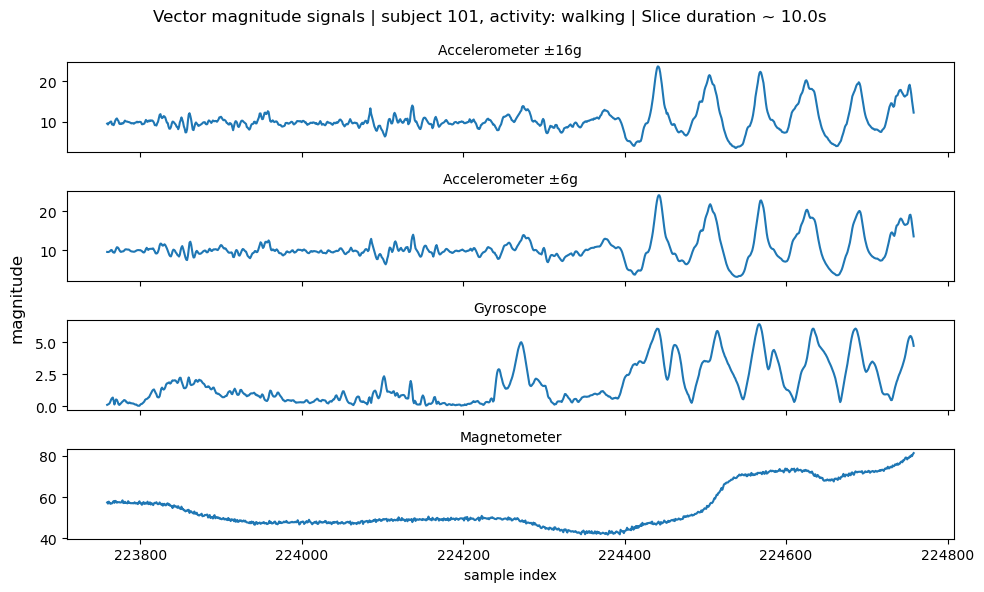

In [5]:
# --- Example Visualization (one subject, one activity) ---

# Selecting an example subject and activity
example_subject = 101 # subject_id: 101-109
example_activity = 4  # choose from ACTIVITY_MAP keys (e.g., 4 = walking)

example = data[
    (data["subject_id"] == example_subject) &
    (data["activity_id"] == example_activity)
]

if example.empty:
    raise ValueError(
        f"Activity {example_activity} ({ACTIVITY_MAP.get(example_activity, 'unknown')}) "
        f"not found for subject {example_subject}"
    )

example = example.iloc[:1000]

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True, sharey=False)

signals = [
    ("hand_acc16_mag", "Accelerometer ±16g"),
    ("hand_acc6_mag",  "Accelerometer ±6g"),
    ("hand_gyro_mag",  "Gyroscope"),
    ("hand_mag_mag",   "Magnetometer"),
]

for ax, (col, subtitle) in zip(axes, signals):
    ax.plot(example[col])
    ax.set_title(subtitle, fontsize=10)
    ax.set_ylabel("")

activity_name = ACTIVITY_MAP.get(example_activity, str(example_activity))
axes[-1].set_xlabel("sample index")
duration_s = float(example["timestamp_s"].iloc[-1] - example["timestamp_s"].iloc[0])
fig.suptitle(
    f"Vector magnitude signals | subject {example_subject}, activity: {activity_name} | Slice duration ~ {duration_s:.1f}s",
    y=0.98,
)

# one shared y-label
fig.supylabel("magnitude")

plt.tight_layout()
plt.show()


## 4. Windowing

We segment the continuous wrist IMU signals into **fixed-length sliding windows**, which are the basic samples used for feature extraction and modeling in wearable activity recognition.

We use a **5-second window** with **50% overlap**, a common and widely accepted choice in HAR that balances temporal context with responsiveness. Windowing is performed **within each subject** to preserve temporal structure and avoid leakage. The effective **sampling rate is estimated from timestamps** to translate time-based window definitions (seconds) into sample indices in a data-driven way.

Each window is assigned a single activity label using a **majority vote** over the samples it contains. To reduce label noise near activity transitions, we apply a **label purity threshold of 0.8** (a common choice in HAR) and **discard windows below this threshold**, focusing the model on learning from **steady-state activities** rather than ambiguous transition regions.


In [6]:
WINDOW_SEC = 5.0
OVERLAP = 0.5
PURITY_THRESHOLD = 0.8

# Channels used for windowing (wrist axes + magnitude signals)
MAG_COLS = ["hand_acc16_mag", "hand_acc6_mag", "hand_gyro_mag", "hand_mag_mag"]
SIGNAL_COLS = hand_keep + MAG_COLS  # hand_keep was defined in Section 2

# Estimate sampling rate from timestamps (we use median for robustness against small jitters)
dt = data.groupby("subject_id")["timestamp_s"].diff().dropna()
fs = int(round(1.0 / dt.median()))
win_size = int(round(WINDOW_SEC * fs))
step = int(round(win_size * (1.0 - OVERLAP)))

print(f"Estimated fs: {fs} Hz | window: {win_size} samples ({WINDOW_SEC}s) | step: {step} samples ({OVERLAP:.0%} overlap)")

Estimated fs: 100 Hz | window: 500 samples (5.0s) | step: 250 samples (50% overlap)


In [7]:
X_windows, y_windows, groups = [], [], []
per_subject_counts = []

for sid, df in data.sort_values(["subject_id", "timestamp_s"]).groupby("subject_id"):
    X = df[SIGNAL_COLS].to_numpy(dtype=np.float32)
    y = df["activity_id"].to_numpy(dtype=np.int32)

    n = len(df)
    kept = 0
    total = 0

    for start in range(0, n - win_size + 1, step):
        y_w = y[start : start + win_size]
        total += 1

        # majority label + purity
        labels, counts = np.unique(y_w, return_counts=True)
        k = counts.argmax()
        purity = counts[k] / win_size

        if purity >= PURITY_THRESHOLD:
            X_windows.append(X[start : start + win_size])
            y_windows.append(labels[k])
            groups.append(sid)
            kept += 1

    per_subject_counts.append({"subject_id": sid, "n_windows": kept, "kept_fraction": kept / max(total, 1)})

X_windows = np.stack(X_windows)
y_windows = np.array(y_windows, dtype=np.int32)
groups = np.array(groups, dtype=np.int32)

print("Windows:", X_windows.shape, "| Labels:", y_windows.shape, "| Groups:", groups.shape)

Windows: (7645, 500, 17) | Labels: (7645,) | Groups: (7645,)


,n_windows,kept_fraction
subject_id,,
101,983,0.984970
102,1037,0.985741
103,685,0.984195
104,912,0.987013
105,1075,0.988051
106,984,0.984985
107,913,0.981720
108,1032,0.985673
109,24,1.000000


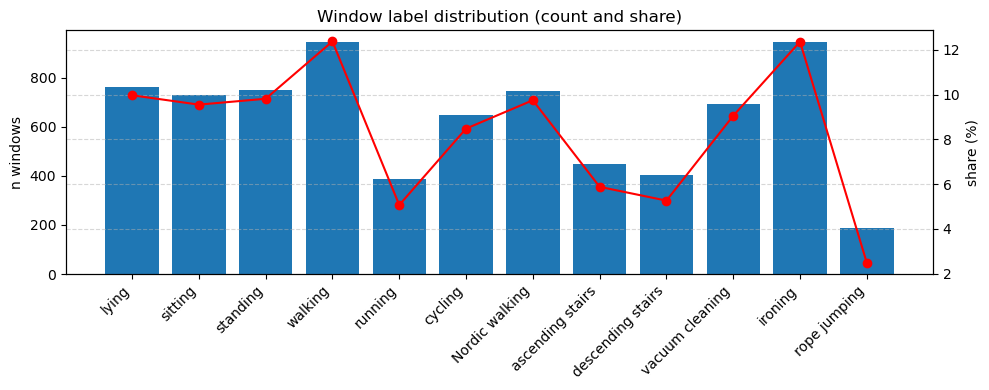

In [8]:
# Minimal sanity summaries
window_counts = pd.DataFrame(per_subject_counts).set_index("subject_id")
display(window_counts)


# label distribution (counts + percent)
label_counts = pd.Series(y_windows).value_counts().sort_index()
label_pct = 100 * label_counts / label_counts.sum()

x_labels = [ACTIVITY_MAP.get(aid, str(aid)) for aid in label_counts.index]
x = np.arange(len(x_labels))

fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.bar(x, label_counts.values)
ax1.set_ylabel("n windows")
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(x, label_pct.values, marker="o", color="red")
ax2.set_ylabel("share (%)")
ax2.grid(axis="y", linestyle="--", alpha=0.5)

plt.title("Window label distribution (count and share)")
plt.tight_layout()
plt.show()

## 5. Feature extraction

In this section, we convert each windowed wrist IMU signal into a **fixed-length feature vector** suitable for classical machine learning models.

For each window and each signal, we compute the following **simple time-domain features**:

- mean  
- standard deviation  
- median  
- minimum  
- maximum  
- interquartile range (IQR)  
- root mean square (RMS)

These statistics capture signal level, variability, range, and overall energy within the window.

This feature-based representation is a **standard approach in wearable activity recognition** for classical models such as logistic regression and gradient boosting. More complex energy-style or frequency-domain features are intentionally omitted here to keep the notebook compact and focused.


In [9]:
def iqr(x: np.ndarray) -> float:
    return float(np.percentile(x, 75) - np.percentile(x, 25))

def rms(x: np.ndarray) -> float:
    return float(np.sqrt(np.mean(x ** 2)))

FEATURE_FUNCS = {
    "mean": lambda x: float(np.mean(x)),
    "std":  lambda x: float(np.std(x, ddof=0)),
    "median": lambda x: float(np.median(x)),
    "min":  lambda x: float(np.min(x)),
    "max":  lambda x: float(np.max(x)),
    "iqr":  iqr,
    "rms":  rms,
}

# Signals to featurize: wrist channels + vector magnitudes
MAG_COLS = ["hand_acc16_mag", "hand_acc6_mag", "hand_gyro_mag", "hand_mag_mag"]
SIGNAL_COLS = hand_keep + MAG_COLS

def featurize_windows(X: np.ndarray, signal_cols: list[str], feature_funcs: dict) -> tuple[np.ndarray, list[str]]:
    """
    X: (n_windows, win_size, n_signals)
    returns: (n_windows, n_features), feature_names
    """
    n_windows, _, n_signals = X.shape
    feats = []
    names = []

    for j, sig in enumerate(signal_cols):
        xj = X[:, :, j]  # (n_windows, win_size)
        for fname, f in feature_funcs.items():
            feats.append(np.apply_along_axis(f, 1, xj))
            names.append(f"{sig}__{fname}")

    X_feat = np.column_stack(feats).astype(np.float32)
    return X_feat, names

X_feat, feature_names = featurize_windows(X_windows, SIGNAL_COLS, FEATURE_FUNCS)

print("Feature matrix:", X_feat.shape)
print("n_features:", len(feature_names))


Feature matrix: (7645, 119)
n_features: 119


As a lightweight sanity check, we inspect the **univariate distributions** of a small number of representative features. This helps verify that the extracted features have sensible ranges and capture differences across activities, without performing extensive exploratory analysis.

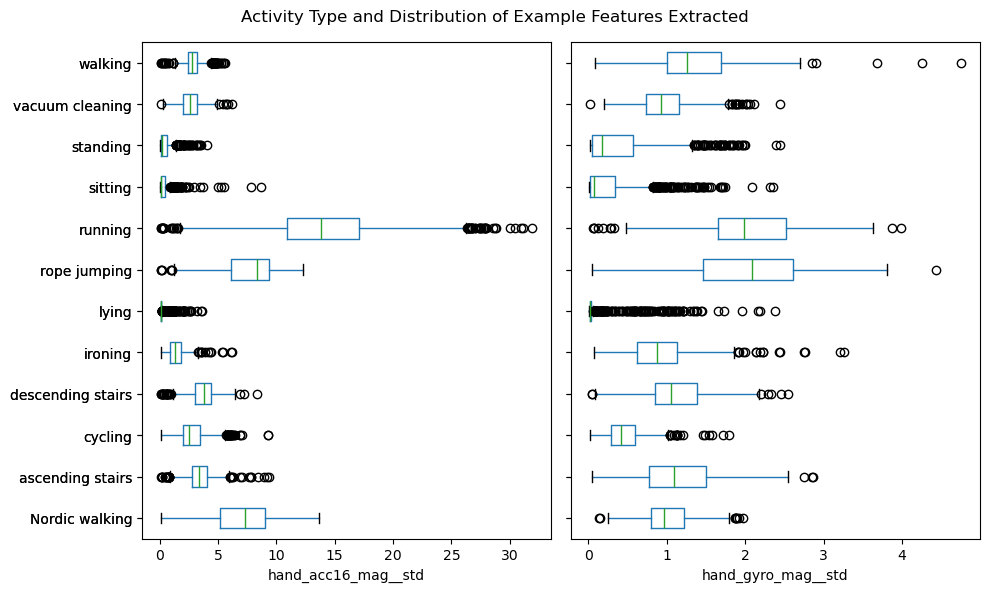

In [10]:
features_to_plot = [
    "hand_acc16_mag__std",
    "hand_gyro_mag__std",
]

df_plot = pd.DataFrame({"activity_id": y_windows})
df_plot["activity"] = df_plot["activity_id"].map(ACTIVITY_MAP)

for feat_name in features_to_plot:
    idx = feature_names.index(feat_name)
    df_plot[feat_name] = X_feat[:, idx]

fig, axes = plt.subplots(1, len(features_to_plot), figsize=(10, 6), sharey=True)

for ax, feat_name in zip(axes, features_to_plot):
    df_plot.boxplot(
        column=feat_name,
        by="activity",
        ax=ax,
        grid=False,
        vert=False,   # <-- "coordflip"
    )
    ax.set_title("")
    ax.set_xlabel(feat_name)
    ax.set_ylabel("")

plt.suptitle("Activity Type and Distribution of Example Features Extracted")
plt.tight_layout()
plt.show()



## 6. Modeling & subject-wise evaluation

In this section, we train and evaluate classical activity recognition models using the extracted window-level features, with a validation protocol that reflects **generalization to unseen users**.

We use **GroupKFold cross-validation**, grouping by `subject_id`, to ensure that windows from the same subject never appear in both training and test folds. This avoids subject-level leakage and mirrors real wearable deployment scenarios.

We evaluate two model families:
- **Logistic Regression (LR)** as a simple, interpretable baseline (with feature standardization).
- **Histogram-based Gradient Boosting (HGB)** as a stronger classical model for tabular data.

For each model, we compare performance using:
- the **original feature space**, and
- a **PCA-compressed feature space**, where PCA retains **90% of the variance** and is fit **within each training fold** via a pipeline to avoid leakage.

The PCA-based evaluation is included **to relate model performance to the upcoming decision boundary visualizations in PCA space**, rather than to mimic a real deployment setup.

We report **macro-F1** (primary metric) and **balanced accuracy** (secondary metric), summarized as mean ± standard deviation across folds.

The results of this section provide a quantitative basis for comparing models and feature representations, and set the stage for the interpretability visualizations in the final section.


In [18]:
import warnings
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
from tqdm import tqdm

# Silence known, expected metric warnings in subject-wise CV;
# label sparsity is explicitly inspected via the fold-wise label distribution shown below
warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

RANDOM_STATE = 42

cv = GroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
splits = list(cv.split(X_feat, y_windows, groups=groups))
all_labels = np.sort(np.unique(y_windows))

pipelines = {
    "LR": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ]),
    "LR+PCA(90%)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.90, svd_solver="full")),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ]),
    "HGB": Pipeline([
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE)),
    ]),
    "HGB+PCA(90%)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.90, svd_solver="full")),
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE)),
    ]),
}

# --- Label counts across folds (computed once) ---
fold_label_rows = []
for fold, (_, te_idx) in enumerate(splits):
    y_te = y_windows[te_idx]
    counts = pd.Series(y_te).value_counts()
    fold_label_rows.append({
        "fold": fold,
        **{ACTIVITY_MAP.get(l, str(l)): int(counts.get(l, 0)) for l in all_labels},
    })

fold_label_counts = pd.DataFrame(fold_label_rows).sort_values("fold")

# --- CV evaluation ---
rows = []
all_fold_scores = []
oof = {name: {"y_true": [], "y_pred": [], "groups": []} for name in pipelines}
for name, pipe in pipelines.items():
    fold_scores = []

    for fold, (tr_idx, te_idx) in enumerate(tqdm(splits, desc=f"CV: {name}")):
        X_tr, X_te = X_feat[tr_idx], X_feat[te_idx]
        y_tr, y_te = y_windows[tr_idx], y_windows[te_idx]

        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_te)

        oof[name]["y_true"].append(y_te)
        oof[name]["y_pred"].append(y_pred)
        oof[name]["groups"].append(groups[te_idx])

        macro_f1 = f1_score(
            y_te, y_pred,
            average="macro",
            labels=all_labels,
            zero_division=0,
        )
        bal_acc = balanced_accuracy_score(y_te, y_pred)
        
        fold_scores.append({
            "fold": fold,
            "macro_f1": macro_f1,
            "bal_acc": bal_acc,
        })
        
        all_fold_scores.append({
            "model": name,
            "fold": fold,
            "macro_f1": macro_f1,
            "bal_acc": bal_acc,
        })

    df_scores = pd.DataFrame(fold_scores)
    rows.append({
        "model": name,
        "macro_f1_mean": df_scores["macro_f1"].mean(),
        "macro_f1_std": df_scores["macro_f1"].std(ddof=1),
        "bal_acc_mean": df_scores["bal_acc"].mean(),
        "bal_acc_std": df_scores["bal_acc"].std(ddof=1),
    })

for name in oof:
    oof[name]["y_true"] = np.concatenate(oof[name]["y_true"])
    oof[name]["y_pred"] = np.concatenate(oof[name]["y_pred"])
    oof[name]["groups"] = np.concatenate(oof[name]["groups"])

results = pd.DataFrame(rows).sort_values("macro_f1_mean", ascending=False)

print("Model performance (GroupKFold, mean ± std)")
display(results)

print("Test-fold label counts (5 folds)")
display(fold_label_counts)


CV: HGB+PCA(90%): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.60s/it]

Model performance (GroupKFold, mean ± std)


,model,macro_f1_mean,macro_f1_std,bal_acc_mean,bal_acc_std
0,LR,0.711154,0.118526,0.760811,0.120261
3,HGB+PCA(90%),0.702619,0.066123,0.757207,0.069615
1,LR+PCA(90%),0.682259,0.120925,0.736321,0.108132
2,HGB,0.658061,0.181828,0.713408,0.147955


Test-fold label counts (5 folds)


,fold,lying,sitting,standing,walking,running,cycling,Nordic walking,ascending stairs,descending stairs,vacuum cleaning,ironing,rope jumping
0,0,189,178,201,254,101,199,232,111,95,178,245,86
1,1,200,184,181,189,174,174,186,112,101,173,243,50
2,2,87,114,81,115,0,0,0,39,58,80,111,24
3,3,185,207,186,254,98,186,213,119,104,176,230,29
4,4,101,47,101,134,14,89,114,68,44,85,116,0


## 7. Results & error analysis

We summarize the modeling results using a small set of diagnostic plots focused on **performance stability** and **error structure**.

First, we compare models using their **fold-wise macro-F1 distributions**, which highlights both average performance and variability across subject-wise folds.

We then inspect the **aggregated confusion matrix** for the best-performing model to understand common confusions between activities.

Finally, we visualize **per-subject macro-F1 variability** for the best model to assess how performance differs across users.


### 7.1 Model performance stability

We first compare models using their **fold-wise macro-F1 distributions** across subject-wise cross-validation splits. This visualization highlights not only average performance, but also **stability across folds**, which is important when evaluating generalization to unseen users.

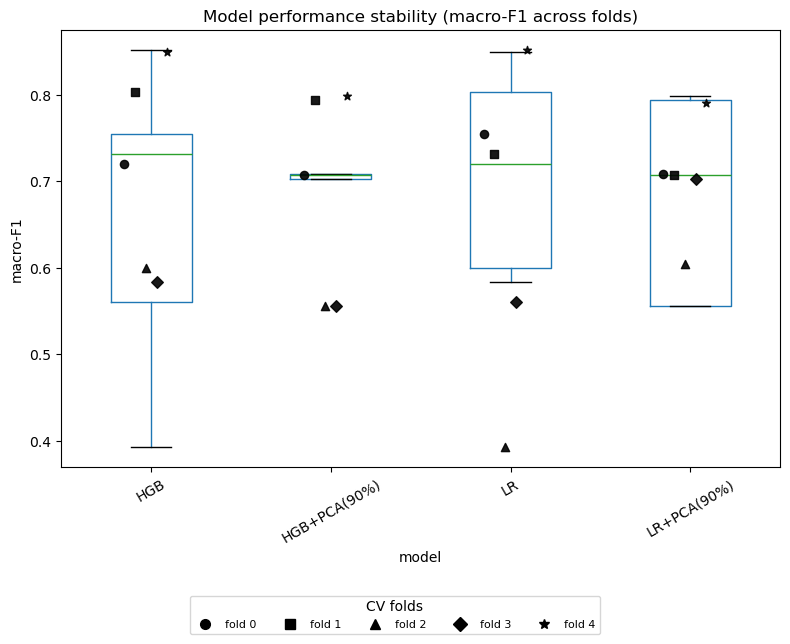

In [127]:
df_fold_scores = pd.DataFrame(all_fold_scores)

fig, ax = plt.subplots(figsize=(8, 6))
df_fold_scores.boxplot(column="macro_f1", by="model", grid=False, rot=30, ax=ax, showfliers=False)
ax.set_title("Model performance stability (macro-F1 across folds)")
fig.suptitle("")
ax.set_ylabel("macro-F1")

# Overlay fold points (different black markers, slight jitter)
models = list(df_fold_scores["model"].unique())
xmap = {m: i + 1 for i, m in enumerate(models)}

fold_markers = ["o", "s", "^", "D", "*"]
folds = sorted(df_fold_scores["fold"].unique())
jitter = 0.06  # small horizontal jitter

import matplotlib.lines as mlines
marker_handles = []

for i, (f, marker) in enumerate(zip(folds, fold_markers)):
    tmp = df_fold_scores[df_fold_scores["fold"] == f]
    x = tmp["model"].map(xmap) + (i - len(folds) / 2) * jitter
    ax.scatter(
        x,
        tmp["macro_f1"],
        marker=marker,
        c="black",
        s=35,
        alpha=0.9,
        zorder=3,
    )
    marker_handles.append(
        mlines.Line2D(
            [], [], linestyle="None", marker=marker, color="black",
            markersize=7, label=f"fold {f}"
        )
    )

# Legend outside (figure-level, bottom)
fig.legend(
    handles=marker_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=len(marker_handles),
    frameon=True,
    fontsize=8,
    title="CV folds",
)

plt.tight_layout()
plt.show()


### 7.2 Aggregated confusion matrix

We inspect the **aggregated confusion matrix** for the best-performing model (based on mean macro-F1). This helps identify systematic confusions between activity classes and provides insight into common failure modes.

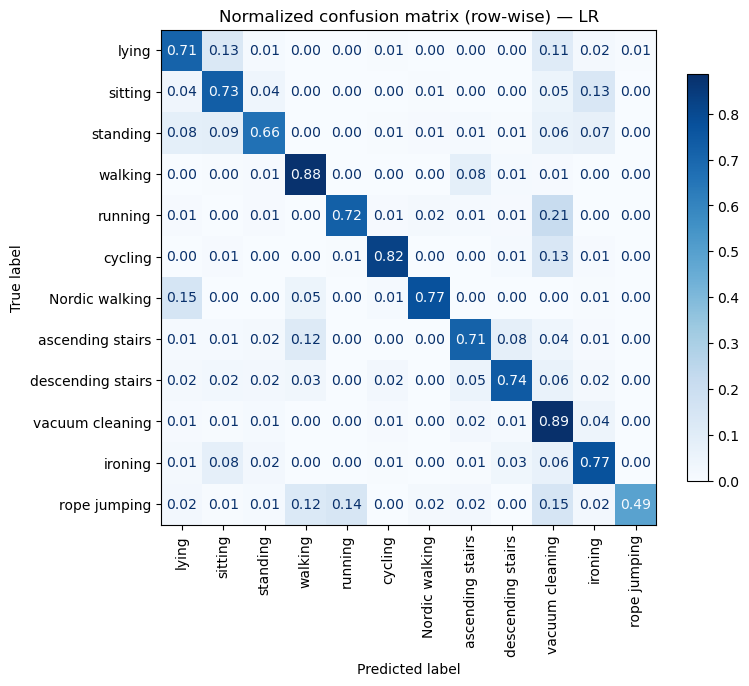

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

best_model_name = results.iloc[0]["model"]

y_true_all = oof[best_model_name]["y_true"]
y_pred_all = oof[best_model_name]["y_pred"]

cm = confusion_matrix(y_true_all, y_pred_all, labels=all_labels, normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[ACTIVITY_MAP[l] for l in all_labels],
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False, values_format=".2f")
plt.colorbar(disp.im_, shrink=0.6) 
ax.set_title(f"Normalized confusion matrix (row-wise) — {best_model_name}")
fig.tight_layout()
plt.show()

### 7.3 Per-subject performance variability

Finally, we analyze **per-subject macro-F1 performance** for the best model. This highlights how recognition accuracy varies across individuals, an important consideration for wearable deployment scenarios.

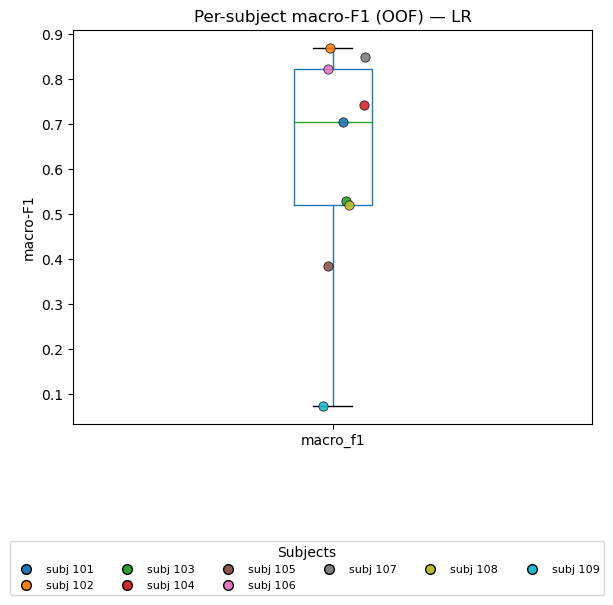

In [130]:
best_model_name = results.iloc[0]["model"]

y_true_oof = oof[best_model_name]["y_true"]
y_pred_oof = oof[best_model_name]["y_pred"]
groups_oof = oof[best_model_name]["groups"]

df_oof = pd.DataFrame({
    "subject_id": groups_oof,
    "y_true": y_true_oof,
    "y_pred": y_pred_oof,
})

per_subject_rows = []
for sid, d in df_oof.groupby("subject_id"):
    per_subject_rows.append({
        "subject_id": sid,
        "macro_f1": f1_score(
            d["y_true"], d["y_pred"],
            average="macro",
            labels=all_labels,
            zero_division=0,
        )
    })

per_subject = pd.DataFrame(per_subject_rows).sort_values("subject_id")

# Color map per subject (deterministic)
subjects = per_subject["subject_id"].tolist()
K = len(subjects)
cmap = matplotlib.colormaps.get_cmap("tab10").resampled(K)
subj2color = {sid: cmap(i) for i, sid in enumerate(subjects)}

fig, ax = plt.subplots(figsize=(6, 6))
per_subject.boxplot(column="macro_f1", ax=ax, grid=False)

# Overlay individual points (colored by subject) with slight jitter
rng = np.random.RandomState(RANDOM_STATE)
x = 1 + rng.normal(loc=0.0, scale=0.04, size=len(per_subject))

import matplotlib.lines as mlines
handles = []
for i, row in enumerate(per_subject.itertuples(index=False)):
    ax.scatter(
        x[i],
        row.macro_f1,
        s=45,
        color=subj2color[row.subject_id],
        edgecolors="black",
        linewidths=0.5,
        alpha=0.9,
        zorder=3,
    )
    handles.append(
        mlines.Line2D(
            [], [], linestyle="None", marker="o",
            markerfacecolor=subj2color[row.subject_id],
            markeredgecolor="black",
            markersize=7,
            label=f"subj {int(row.subject_id)}",
        )
    )

ax.set_title(f"Per-subject macro-F1 (OOF) — {best_model_name}")
ax.set_ylabel("macro-F1")

# Legend outside bottom (horizontal)
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=min(len(handles), 6),
    frameon=True,
    fontsize=8,
    title="Subjects",
)

plt.tight_layout(rect=[0, 0.22, 1, 1])
plt.show()


### 7.4 Results summary

**Overall model comparison (GroupKFold, subject-wise):**
- **Best mean performance:** **LR (original features)** achieved **macro-F1 = 0.71 ± 0.12** and **balanced accuracy = 0.76 ± 0.12**.
- **Most stable across folds:** **HGB+PCA(90%)** was close in mean performance (**macro-F1 = 0.70 ± 0.07**, **bal-acc = 0.76 ± 0.07**) with visibly tighter variability than the other variants.
- **PCA impact:** PCA slightly reduced LR performance on average (LR+PCA macro-F1 ≈ 0.68), while HGB benefited from PCA in stability (HGB+PCA vs HGB).

**Error structure (normalized confusion matrix, LR):**
- Several activities show strong recall (row-wise): e.g., **walking (~0.88)**, **vacuum cleaning (~0.89)**, **cycling (~0.82)**.
- The hardest class in this subset is **rope jumping** (**~0.49** recall), with confusions spread across high-motion classes (notably walking/running/vacuum cleaning).
- Some expected confusions appear among semantically/kinematically similar classes:
  - **standing** mixes with **lying/sitting**.
  - **running** shows noticeable confusion with **vacuum cleaning** in this split.

**Per-subject variability (OOF macro-F1, LR):**
- Performance varies substantially across users: from **~0.87 (best subject)** down to **~0.07 (worst subject)**.
- This highlights that while the global model generalizes reasonably on average, **user-level differences and intra-subject physiological variability** are a major source of uncertainty, motivating **per-user calibration or personalization** in practical wearable deployments.


## 8. Model interpretability in PCA space

In this final section, we build intuition about how the trained models separate activity classes by visualizing their **decision regions in PCA space**.

After cross-validation is complete, we refit the PCA-based pipelines **once on the full dataset**, using the same default settings as in Section 6. This refit is performed purely for **interpretability and visualization**, not for estimating performance.

Because the PCA-based models operate in a **higher-dimensional PCA space** (retaining 90% of variance), but decision boundary plots can only be shown in 2D, we visualize a **2D slice** of the full model in the **PC1–PC2 plane**:

- We create a grid in the **PC1–PC2** plane.
- We embed these grid points into the full PCA space by setting the remaining PCs (PC3 … PCk) to **0**, corresponding to their mean values in centered PCA coordinates.
- We map these points back to the original feature space via inverse transforms and obtain predictions from the **original trained model**.

This approach follows standard practice in applied machine learning when visualizing high-dimensional classifiers: PCA components are zero-centered by construction (see e.g. *Jolliffe & Cadima, 2016, “Principal Component Analysis: A Review and Recent Developments”*), so fixing higher components at zero corresponds to holding them at their average values. The inverse PCA transformation used here is the same mechanism described in the scikit-learn PCA documentation and textbooks on linear dimensionality reduction.

The resulting decision regions are therefore **faithful to the full PCA-based model**, but should be interpreted as model behavior along PC1–PC2 **with all other PCA directions held constant**. This kind of 2D slicing is widely used for interpretability and visualization, while performance is always evaluated in the full feature space or a sufficiently rich reduced space (e.g. 90–95% variance PCA), rather than in only two components.

To aid interpretation, we overlay:
- a random global subsample of windows

Finally, we inspect the **PC1 and PC2 loadings** (top absolute contributors of each independantly) to see which original features most strongly drive the dominant PCA direction used in the visualization.

### 8.1 Global overlay of random subsample of windows

In [69]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import BaseEstimator, ClassifierMixin

SUBSAMPLE_SIZE = 100
rng = np.random.RandomState(RANDOM_STATE)

# 1) Fit PCA(90%) on full feature matrix (for visualization only)
pca_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.90, svd_solver="full")),
])
Z_full = pca_pipe.fit_transform(X_feat)  # (n_windows, n_pcs)
n_pcs = pca_pipe.named_steps["pca"].n_components_
print("PCA components kept:", n_pcs)

# 2) Refit models in PCA space (same setting as Section 6; visualization only)
lr_clf = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
hgb_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

lr_clf.fit(Z_full, y_windows)
hgb_clf.fit(Z_full, y_windows)

# 3) Random global subsample overlay (for readability)
plot_idx = rng.choice(len(y_windows), size=min(SUBSAMPLE_SIZE, len(y_windows)), replace=False)
Z2 = Z_full[:, :2]  # PC1, PC2 coordinates of all windows

# 4) sklearn-compatible wrapper: map (PC1,PC2) -> full PCA space (PC3..=0) -> clf.predict()
class PC12Wrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, clf, n_pcs):
        self.clf = clf
        self.n_pcs = n_pcs

    def fit(self, X=None, y=None):
        # nothing to train; satisfy sklearn estimator interface checks
        self.classes_ = getattr(self.clf, "classes_", None)
        self.is_fitted_ = True
        return self

    def predict(self, Z2_grid):
        Zg = np.zeros((Z2_grid.shape[0], self.n_pcs), dtype=np.float64)
        Zg[:, :2] = Z2_grid
        return self.clf.predict(Zg)

wrappers = {
    "LR (PCA space)": PC12Wrapper(lr_clf, n_pcs).fit(),
    "HGB (PCA space)": PC12Wrapper(hgb_clf, n_pcs).fit(),
}

PCA components kept: 17


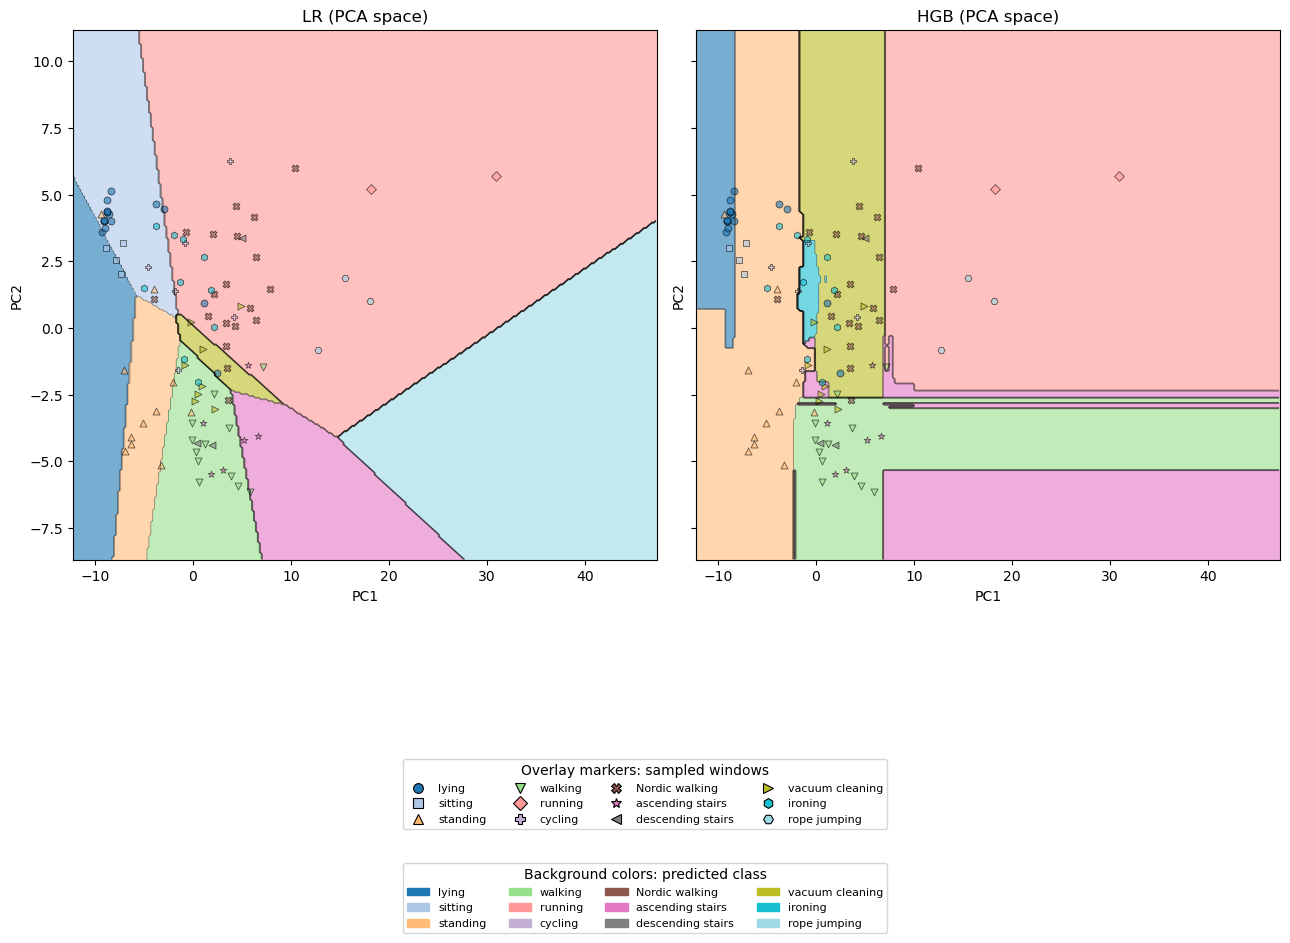

In [70]:
import matplotlib
# Controls
REGION_ALPHA = 0.6
EDGE_ALPHA = 0.6
MARKER_ALPHA = 0.6
MARKER_EDGE_W = 0.6
BOUNDARY_LW = 0.4

# Unique labels (global, for consistent colors across both models)
labels_sorted = list(all_labels)
lab2i = {lab: i for i, lab in enumerate(labels_sorted)}
K = len(labels_sorted)

# Colormap (enough distinct colors for up to 20 classes)
cmap = matplotlib.colormaps.get_cmap("tab20").resampled(K)

# Mesh grid in PC1–PC2 space
x_min, x_max = Z2[:, 0].min(), Z2[:, 0].max()
y_min, y_max = Z2[:, 1].min(), Z2[:, 1].max()
pad_x = 0.05 * (x_max - x_min)
pad_y = 0.05 * (y_max - y_min)
x_min, x_max = x_min - pad_x, x_max + pad_x
y_min, y_max = y_min - pad_y, y_max + pad_y

grid_res = 300
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_res),
    np.linspace(y_min, y_max, grid_res),
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict on grid for both models (wrapper expects PC1–PC2 and internally fills PC3..=0)
pred_lr = wrappers["LR (PCA space)"].predict(grid)
pred_hgb = wrappers["HGB (PCA space)"].predict(grid)

# Convert predicted labels -> integer indices for consistent coloring
Z_lr = np.vectorize(lab2i.get)(pred_lr).reshape(xx.shape)
Z_hgb = np.vectorize(lab2i.get)(pred_hgb).reshape(xx.shape)

# Markers for the activities present in the overlay sample
marker_cycle = ["o", "s", "^", "v", "D", "P", "X", "*", "<", ">", "h", "H", "p", "8", "+", "x", "1", "2"]
uniq_overlay_labels = np.sort(np.unique(y_windows[plot_idx]))
marker_map = {lab: marker_cycle[i % len(marker_cycle)] for i, lab in enumerate(uniq_overlay_labels)}

fig, axes = plt.subplots(1, 2, figsize=(13, 8), sharex=True, sharey=True)

def draw_regions(ax, Z_idx):
    im = ax.pcolormesh(
        xx, yy, Z_idx,
        cmap=cmap, shading="auto",
        alpha=REGION_ALPHA, vmin=0, vmax=K-1,
    )
    ax.contour(
        xx, yy, Z_idx,
        levels=np.arange(-0.5, K, 1),
        colors="black",
        linewidths=BOUNDARY_LW,
        alpha=EDGE_ALPHA,
    )
    return im

# Background decision regions (same cmap + same alpha for both)
im0 = draw_regions(axes[0], Z_lr)
_ = draw_regions(axes[1], Z_hgb)

# Overlay points with activity-colored markers (opaque face + black edge)
for ax, title in zip(axes, ["LR (PCA space)", "HGB (PCA space)"]):
    for lab in uniq_overlay_labels:
        idx = plot_idx[y_windows[plot_idx] == lab]
        ax.scatter(
            Z2[idx, 0], Z2[idx, 1],
            s=25,
            marker=marker_map[lab],
            alpha=MARKER_ALPHA,
            facecolors=[cmap(lab2i[lab])],
            edgecolors="black",
            linewidths=MARKER_EDGE_W,
        )
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# ---- Legends outside bottom (two separate legends, with titles) ----
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# 1) Background class colors legend (global)
class_patches = [
    mpatches.Patch(color=cmap(i), label=ACTIVITY_MAP.get(int(lab), str(lab)))
    for i, lab in enumerate(labels_sorted)
]
fig.legend(
    handles=class_patches,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=4,
    frameon=True,
    fontsize=8,
    title="Background colors: predicted class",
)

# 2) Overlay marker legend (only labels present in overlay)
marker_handles = [
    mlines.Line2D(
        [], [],
        linestyle="None",
        marker=marker_map[lab],
        markersize=7,
        markerfacecolor=cmap(lab2i[lab]),
        markeredgecolor="black",
        markeredgewidth=0.8,
        label=ACTIVITY_MAP.get(int(lab), str(lab)),
    )
    for lab in uniq_overlay_labels
]
fig.legend(
    handles=marker_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=4,
    frameon=True,
    fontsize=8,
    title="Overlay markers: sampled windows",
)

# Make room at the bottom so legends don't overlap x-axis labels
plt.tight_layout(rect=[0, 0.22, 1, 1])
plt.show()


### 8.2 PCA loadings

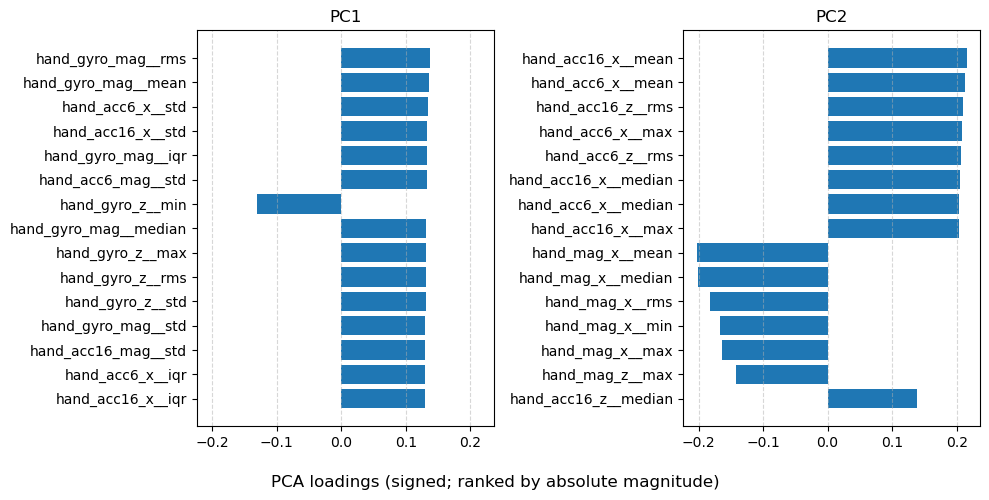

In [81]:
pca = pca_pipe.named_steps["pca"]

pc1 = pd.Series(pca.components_[0], index=feature_names, name="pc1_loading")
pc2 = pd.Series(pca.components_[1], index=feature_names, name="pc2_loading")

top_n = 15

def top_by_abs(series, n):
    top_idx = series.abs().sort_values(ascending=False).head(n).index
    s = series.loc[top_idx]
    # order by absolute magnitude (largest at bottom/top depending on sort), keep sign
    return s.reindex(s.abs().sort_values().index)

pc1_top = top_by_abs(pc1, top_n)
pc2_top = top_by_abs(pc2, top_n)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axes[0].barh(pc1_top.index, pc1_top.values)
axes[0].set_title("PC1")

axes[1].barh(pc2_top.index, pc2_top.values)
axes[1].set_title("PC2")

for ax in axes:
    ax.grid(True, axis="x", linestyle="--", alpha=0.5)

fig.supxlabel("PCA loadings (signed; ranked by absolute magnitude)")

plt.tight_layout()
plt.show()


### 8.3 Comments

The PCA-based visualizations provide qualitative insight into how the models structure activity separation, without serving as a performance assessment tool.

- **PC1–PC2 structure:**  
  The first two principal components reveal some organization of activities.

- **Model behavior differences:**  
  The Logistic Regression decision regions are smooth and globally linear in PCA space, while the Gradient Boosting model forms sharper, axis-aligned regions and stronger nonlinearity observed.

- **Overlap and ambiguity:**  
  Significant overlap remains between related activities.

- **PCA loadings:**  
  PC1 is dominated by **gyroscope magnitude and axis-specific statistics** (mean, RMS, IQR, std), with additional contribution from accelerometer magnitude features. This indicates that PC1 primarily captures **overall wrist motion intensity**, combining rotational and translational energy.  
  PC2 shows strong contributions from **accelerometer axis statistics** (especially x/z mean, RMS, max, median), contrasted by **magnetometer features** with large negative loadings. This suggests PC2 separates **directional linear motion** from **orientation-related or heading-stability cues**. 

Overall, these visualizations support the quantitative results: the models learn reasonable global structure, but **class overlap and subject-specific variability** remain fundamental challenges—motivating personalization or temporal modeling in more advanced setups.
